In [1]:
using PyPlot
using SpecialFunctions

## Chaîne de transmission idéale
### Éléments de la chaîne de transmission
#### Formant

In [2]:
# formantcos.jl
function formantcos(taille, surechantillonnage)
    pi = 3.1415926535
    formant = zeros(taille)
    t = collect(1:taille) - Int((taille+1) / 2) 
    t = t / surechantillonnage
    for i = collect(1:1:taille)
        if t[i]^2 == (1/16)
            formant[i] = pi/4
        else
            formant[i] = cospi(2*t[i]) / (1 - 16 * t[i]^2)
        end
    end
    return formant
end

formantcos (generic function with 1 method)

In [3]:
# formantrect.jl
function formantrect(taille, surechantillonnage)
    pi = 3.1415926535
    formant = zeros(taille)
    t = collect(1:taille) - Int((taille+1) / 2) 
    t = t / surechantillonnage
    for i = collect(1:taille)
        if t[i] == 0
            formant[i] = 1
        else
            formant[i] = sinpi(t[i]) / (pi * t[i])
        end
    end
    return formant
end

formantrect (generic function with 1 method)

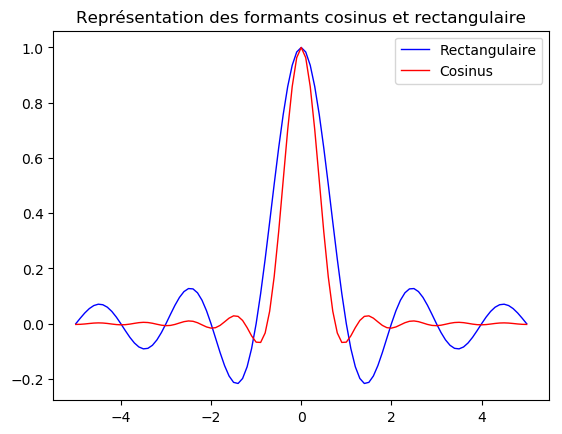

In [4]:
surechantillonnage = 10;
taille_formant = 10 * surechantillonnage + 1;
formant_rect = formantrect(taille_formant, surechantillonnage)
formant_cos = formantcos(taille_formant, surechantillonnage);
xrect = collect(1:length(formant_rect));
xrect = (xrect - (length(formant_rect) + 1) / 2) / surechantillonnage;
xcos = collect(1:length(formant_cos));
xcos = (xcos - (length(formant_cos) + 1) / 2) / surechantillonnage
plot(xrect, formant_rect, "blue", xcos, formant_cos, "red", linewidth=1)
title("Représentation des formants cosinus et rectangulaire")
legend(["Rectangulaire", "Cosinus"])
savefig("formants.png")

#### Emetteur

In [4]:
# emission.jl
function emission(message, formant, surechantillonnage)
    signal = zeros((length(message) - 1) * surechantillonnage + 1)
    signal[1:surechantillonnage:length(signal)] = message
    signal = conv(signal, formant);
    return signal
end

emission (generic function with 1 method)

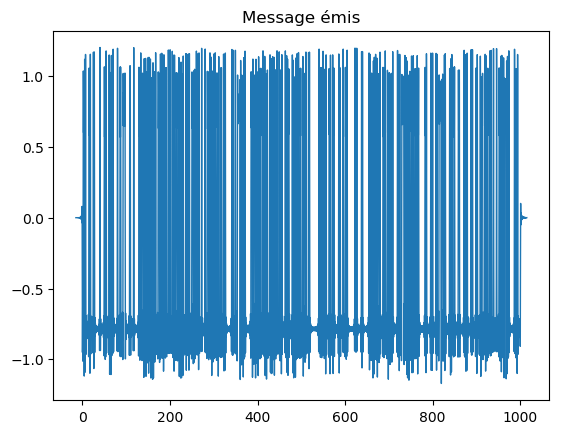

In [6]:
taille_message = 1000
surechantillonnage = 30
taille_formant = 30
message = 2 * (randn(taille_message) .> 0.5) - 1
formant = formantcos(surechantillonnage * taille_formant + 1, surechantillonnage)
signal = emission(message, formant, surechantillonnage)
x = linspace(-taille_formant / 2 + 1 / surechantillonnage, taille_formant / 2 + taille_message, length(signal))
plot(x, signal, linewidth=1);
title("Message émis");
savefig("message.png")

#### Récepteur

In [5]:
# reception.jl
function reception(signal, filtre, surechantillonnage, sync)
    signal = conv(signal, filtre)
    zero = Int((length(filtre)-1)/2 + sync)
    signal = signal[zero:surechantillonnage:length(signal)-zero+1]
    signal = 2 * (signal .> 0) - 1
    return signal
end

reception (generic function with 1 method)

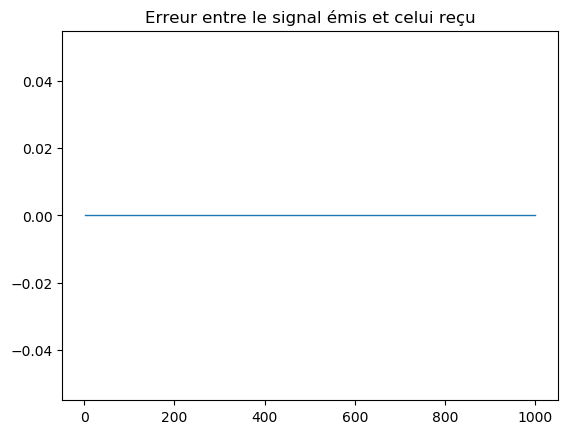

In [8]:
taille_message = 1000;
surechantillonnage = 30;
taille_formant = 30;
message = 2 * (randn(taille_message) .> 0.5) - 1;
formant = formantcos(surechantillonnage*taille_formant+1, surechantillonnage); 
signal = emission(message, formant, surechantillonnage);
filtre = formant[length(formant):-1:1] / (formant'*formant);
recu = reception(signal, filtre, surechantillonnage, 1+taille_formant*surechantillonnage/2); 
recu = recu[1:length(message)];
erreur = abs.(recu-message)/2 
sum(erreur)
x = collect(1:taille_message)
plot(x, erreur, linewidth=1);
title("Erreur entre le signal émis et celui reçu");
savefig("erreur_emis_recu.png")

#### Ajout d'un bruit de canal

In [6]:
# bruit.jl
function bruit(rapport, energie_bit, taille_bruit)
    bruit =  randn(taille_bruit)
    var = energie_bit / (2*10.^(rapport/10))
    bruit = bruit * sqrt.(var)
    return bruit
end

bruit (generic function with 1 method)

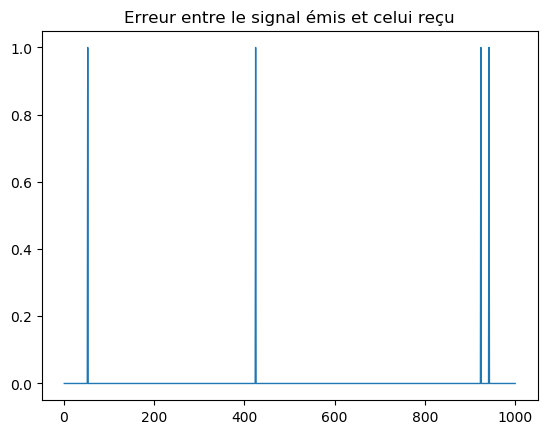

0.0

In [10]:
taille_message = 1000
surechantillonnage = 30
taille_formant = 30
message = 2 * (randn(taille_message) .> 0.5) - 1
formant = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
signal = emission(message, formant, surechantillonnage)
signal = signal + bruit(5, formant'*formant, length(signal))
filtre = formant[length(formant):-1:1] / (formant'*formant)
recu = reception(signal, filtre, surechantillonnage, 1+taille_formant*surechantillonnage/2)
recu = recu[1:length(message)]
erreur_message = abs.(recu-message)/2 
print(sum(erreur))
x = collect(1:taille_message)
plot(x, (recu-message)/2 , linewidth=1);
title("Erreur entre le signal émis et celui reçu");
savefig("erreur_emis_recu_bruitee.png")

### Courbes de taux d'erreur
#### Taux d'erreur théorique de la chaîne de transmission idéale

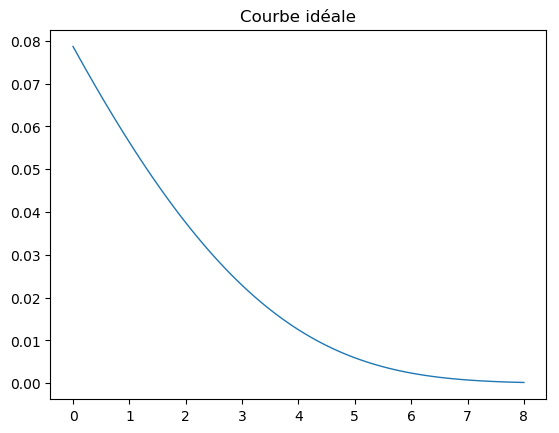

In [11]:
x = collect(0:0.1:8)
y = zeros(length(x))
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)))
end
plot(x, y, linewidth=1);
title("Courbe idéale");
savefig("courbe_ideale.png")

#### Taux d'erreur simulé de la chaîne de transmission idéale

In [7]:
# erreur.jl
function erreur_function(rapport, taille_message, surechantillonnage, formant_base, formant_filtre)
    message = 2 * (randn(taille_message) .> 0.5) - 1;
    signal = emission(message, formant_base, surechantillonnage);
    signal = signal + bruit(rapport, formant_base'*formant_base, length(signal));
    recu = reception(signal, formant_filtre, surechantillonnage, ((length(formant_filtre)-1))/2); 
    recu = recu[1:length(message)];
    erreur = sum(abs.(recu-message)/2)/taille_message;
    return erreur
end

erreur_function (generic function with 1 method)

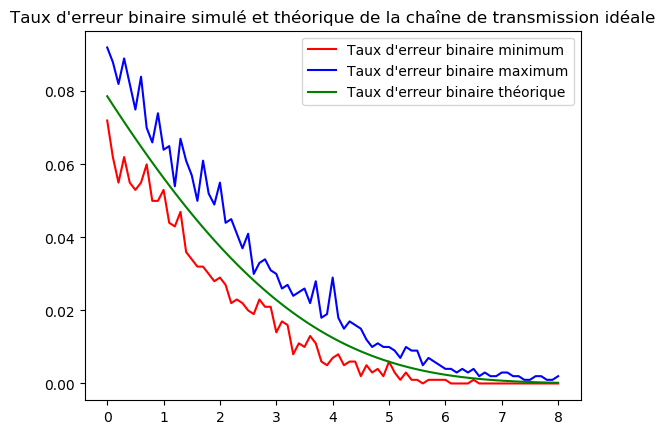

In [13]:
# courbe_ideale_simulee.jl
teb_min = zeros(81);
teb_max = zeros(81);

taille_message = 1000;
surechantillonnage = 30;
taille_formant = 30;
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);

for x = collect(0:0.1:8)
    i = Int(x*10) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:10)
        temp_teb = erreur_function(x, taille_message, surechantillonnage, formant_base, formant_filtre);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end
x = collect(0:0.1:8)
y = zeros(length(x))
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)))
end
plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green")
title("Taux d'erreur binaire simulé et théorique de la chaîne de transmission idéale")
legend(["Taux d'erreur binaire minimum", "Taux d'erreur binaire maximum", "Taux d'erreur binaire théorique"])
savefig("courbe_ideale_simulee.png")

## Chaîne de transmission non-idéale
### Introduction d’une déformation dans le canal

In [8]:
# erreur_canal.jl
function erreur_canal(rapport, taille_message, surechantillonnage, formant_base, formant_filtre, canal)
    message = 2 * (rand(taille_message) .> 0.5) - 1;
    signal = emission(message, formant_base, surechantillonnage);
    signal = conv(signal, canal);
    signal = signal + bruit(rapport, signal'*signal/taille_message, length(signal));
    recu = reception(signal, formant_filtre, surechantillonnage, 1 + (length(formant_base) + length(canal) - 2) / 2); 
    recu = recu[1:length(message)];
    erreur = sum(abs.(recu-message)/2)/taille_message;
end

erreur_canal (generic function with 1 method)

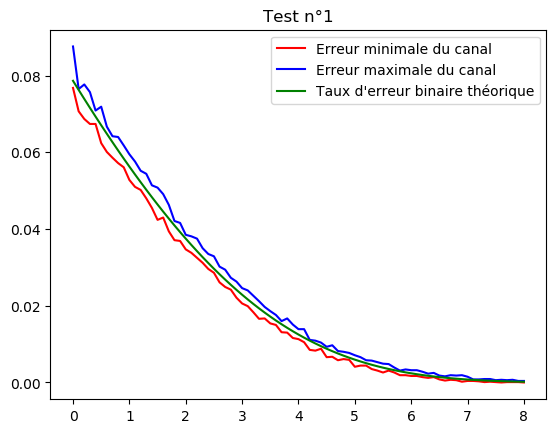

In [15]:
# courbe_canal_simulee_test1.jl
teb_min = zeros(81);
teb_max = zeros(81);
N = 10
taille_message = 10000;
surechantillonnage = 30;
taille_formant = 30;
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);

canal = [1];

for x = collect(0:0.1:8)
    i = Int(x*10) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, formant_filtre, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end
x = collect(0:0.1:8)

y = zeros(length(x))
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)))
end

plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green")
title("Test n°1")
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"])
savefig("courbe_canal_simulee_test1.png")

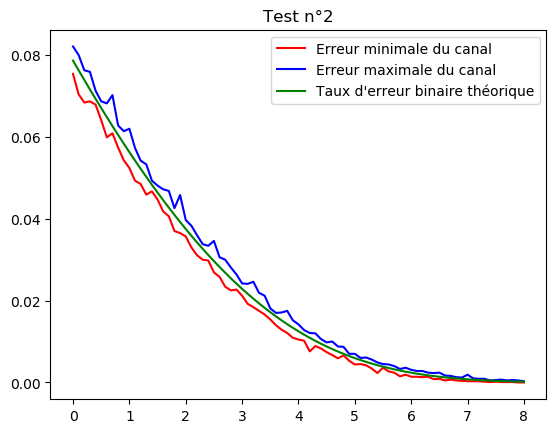

In [16]:
# courbe_canal_simulee_test2.jl
teb_min = zeros(81);
teb_max = zeros(81);
N = 10
taille_message = 10000;
surechantillonnage = 30;
taille_formant = 30;
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);

x_canal = collect(-6:0.01:6);
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid] = 1;

for x = collect(0:0.1:8)
    i = Int(x*10) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, formant_filtre, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end
x = collect(0:0.1:8)

y = zeros(length(x))
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)))
end

plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green")
title("Test n°2")
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"])
savefig("courbe_canal_simulee_test2.png")

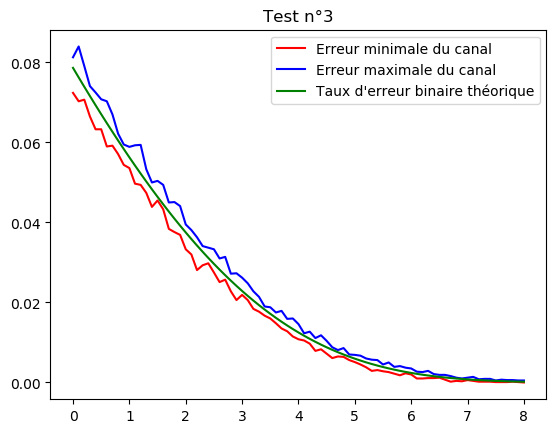

In [17]:
# courbe_canal_simulee_test3.jl
teb_max = zeros(81);
teb_min = zeros(81);
N = 10
taille_message = 10000;
surechantillonnage = 30;
taille_formant = 30;
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);

x_canal = collect(-6:0.01:6);
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid] = 10;

for x = collect(0:0.1:8)
    i = Int(x*10) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, formant_filtre, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end
x = collect(0:0.1:8)

y = zeros(length(x))
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)))
end

plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green")
title("Test n°3")
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"])
savefig("courbe_canal_simulee_test3.png")

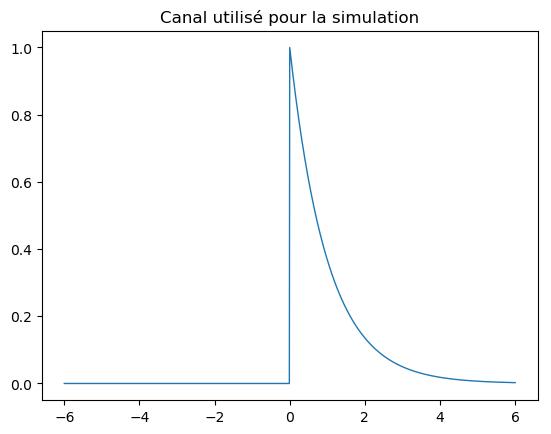

In [18]:
x_canal = collect(-6:0.01:6);
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid:length(canal)] = exp.(-x_canal[mid:length(canal)]);
plot(x_canal, canal, linewidth=1)
title("Canal utilisé pour la simulation")
savefig("canal_simulee.png")

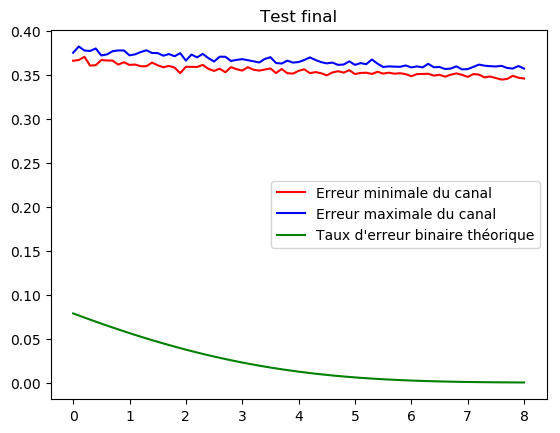

In [19]:
# courbe_canal_simulee.jl
teb_min = zeros(81);
teb_max = zeros(81);
N = 10
taille_message = 10000;
surechantillonnage = 30;
taille_formant = 30;
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);

x_canal = collect(-6:0.01:6);
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid:length(canal)] = exp.(-x_canal[mid:length(canal)]);


for x = collect(0:0.1:8)
    i = Int(x*10) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, formant_filtre, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end
x = collect(0:0.1:8)

y = zeros(length(x))
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)))
end

plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green")
title("Test final")
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"])
savefig("courbe_canal_simulee.png")

### Récepteur adapté au canal déformé
#### Récepteur naïf avec filtre adapté de la chaîne de transmission idéale

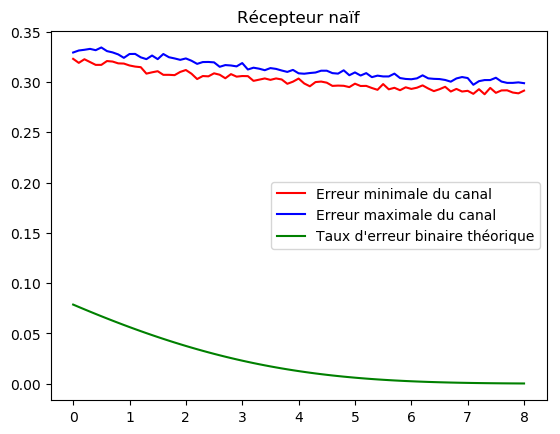

In [9]:
# courbe_canal_simulee_naive.jl
teb_min = zeros(81);
teb_max = zeros(81);
N = 10
taille_message = 10000;
surechantillonnage = 30;
taille_formant = 30;
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);

x_canal = collect(-6:0.01:6);
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid:length(canal)] = exp.(-x_canal[mid:length(canal)]);

filtre = conv(canal, formant_base)
filtre = filtre[end:-1:1]/(filtre'*filtre)

for x = collect(0:0.1:8)
    i = Int(x*10) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, filtre, formant_filtre, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end
x = collect(0:0.1:8)

y = zeros(length(x))
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)))
end

plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green")
title("Récepteur naïf")
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"])
savefig("courbe_canal_simulee_naive.png")

#### Récepteur avec élimination des interférences entre symboles

In [48]:
function calcul_interferences(surechantillonnage, formant, filtre, canal)
    # Cette fonction renvoie le signal analogique en sortie du recepteur
    # lorsqu'on envoie un Dirac comme message. On peut ainsi observer les
    # interférences entre symboles (s'il n'y avait pas d'interférences, la
    # sortie serait un Dirac). 
    nbZeros = 100;
    message = zeros(nbZeros+1)
    message[Int(nbZeros/2+1)] = 1;
    formant = formantcos(surechantillonnage*length(formant)+1, surechantillonnage);
    signal = emission(message, formant, surechantillonnage);
    signal = conv(signal, canal);
    sortie_recepteur = conv(signal, filtre);
    milieu = (length(filtre)-1)/2 + (length(formant)-1)/2 + (length(canal) - 1)/2 +1;
    sortie_recepteur = sortie_recepteur[Int(mod(milieu, surechantillonnage)):surechantillonnage:end];
    return sortie_recepteur
    #   figure, plot((0:length(sortie_recepteur)-1) - (length(sortie_recepteur)-1)/2, sortie_recepteur)
    #   title('Interference entre symboles')
end

calcul_interferences (generic function with 1 method)

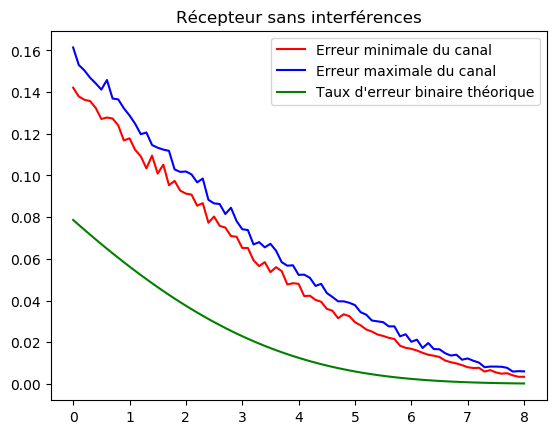

In [115]:
# courbe_canal_simulee_sansinterference.jl
teb_min = zeros(81);
teb_max = zeros(81);
N = 10
taille_message = 10000;
surechantillonnage = 30;
taille_formant = 30;
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);

x_canal = collect(-6*surechantillonnage:6*surechantillonnage)./surechantillonnage;
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid:length(canal)] = exp.(-x_canal[mid:length(canal)]);

filtre = conv(formant_base, canal);
filtre = filtre./(filtre'*filtre);
filtre = filtre[length(filtre):-1:1];

interferences = calcul_interferences(surechantillonnage, formant_base, filtre, canal);

temp = interferences[Int(floor(1+length(interferences)/2)):length(interferences)];
interferences = vcat(temp, interferences[1:Int(floor(length(interferences)/2))]);
interferences_inverses = real(ifft(1./fft(interferences)));

temp = interferences_inverses[1:Int(floor(length(interferences_inverses)/2) + 1)];
interferences_inverses = vcat(interferences_inverses[Int(floor(length(interferences_inverses)/2)+2):length(interferences_inverses)], temp);

interferences_inverses_analogique = zeros(((length(interferences_inverses)-1) * surechantillonnage)+1);
interferences_inverses_analogique[1:surechantillonnage:length(interferences_inverses_analogique)] = interferences_inverses;

filtre_interferences = conv(filtre, interferences_inverses_analogique);

for x = collect(0:0.1:8)
    i = Int(x*10) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, filtre_interferences, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end
x = collect(0:0.1:8)

y = zeros(length(x))
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)))
end

plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green")
title("Récepteur sans interférences")
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"])
savefig("courbe_canal_simulee_sansinterference.png")